In [27]:
import os
import pandas as pd
import imdb
from tqdm import tqdm_notebook as tqdm
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
# Combine data from imdb
info_df = pd.read_csv('data/title.basics.tsv', sep='\t')
ratings_df = pd.read_csv('data/title.ratings.tsv', sep='\t')
all_df = info_df.merge(ratings_df, on='tconst')

In [3]:
# Select our films for the game
movie_df = all_df[all_df['titleType'] == 'movie'] # Movies only
clean_movie_df = movie_df[movie_df['isAdult'] == 0] # No porn
clean_movie_df= clean_movie_df[clean_movie_df['startYear'] != r'\N'] # Has a release year
clean_movie_df['startYear'] = pd.to_numeric(clean_movie_df['startYear']) # release year as int
clean_movie_df.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.6,76
143,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",5.2,289
237,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",6.3,39
343,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",6.2,503
360,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,4.8,14


In [4]:
count_year_df = clean_movie_df.groupby('startYear').size().reset_index(name='counts')

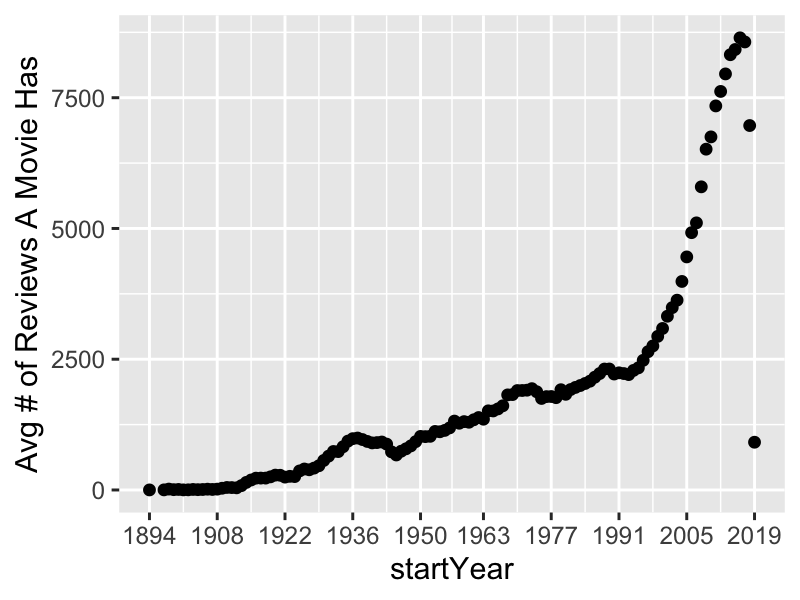

In [7]:
%%R -i count_year_df -w 4 -h 3 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
ggplot(count_year_df, aes(x=startYear, y=counts)) +
    geom_point() +
    scale_x_continuous(breaks=round(seq(1894,2019, length=10))) +
    labs(y='Avg # of Reviews A Movie Has')

In [9]:
votes_90percentile = clean_movie_df[['startYear','numVotes']].groupby('startYear').\
    quantile(0.90).reset_index().rename(columns={'numVotes':'percentile90'})
votes_925percentile = clean_movie_df[['startYear','numVotes']].groupby('startYear').\
    quantile(0.925).reset_index().rename(columns={'numVotes':'percentile925'})
votes_95percentile = clean_movie_df[['startYear','numVotes']].groupby('startYear').\
    quantile(0.95).reset_index().rename(columns={'numVotes':'percentile95'})
votes_df = votes_90percentile.merge(votes_925percentile, on='startYear').\
    merge(votes_95percentile, on='startYear')
long_df = votes_df.melt(id_vars='startYear')

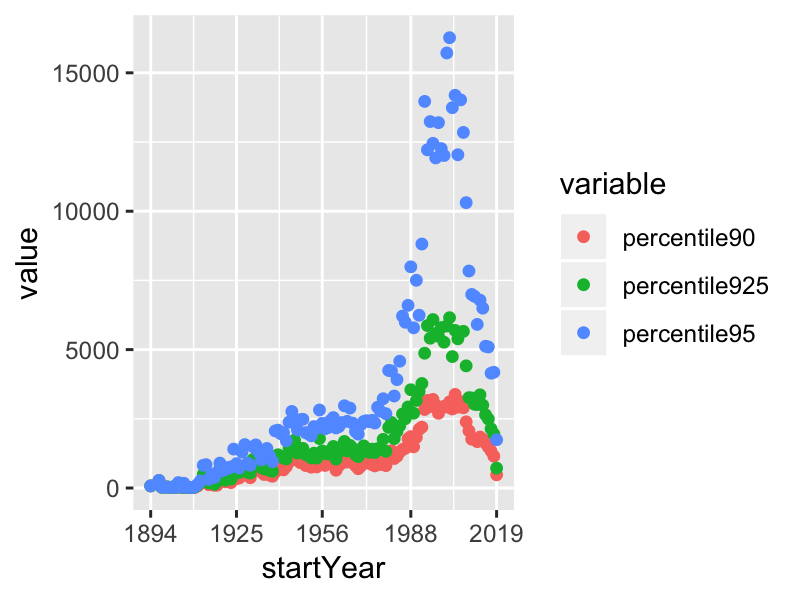

In [7]:
%%R -i long_df -w 4 -h 3 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
ggplot(long_df, aes(x=startYear, y=value, col=variable)) +
    geom_point() +
    scale_x_continuous(breaks=round(seq(1894,2019, length=5))) +
    labs(y='# Of Reviews A Movie Has' x='Year')
    


In [8]:
difficulty_dict = {'easy':'percentile90', 'medium': 'percentile925', 'hard':'percentile95'}
difficulty = 'easy'

In [11]:
def build_difficulty_df(difficulty, clean_movie_df, votes_df, 
                        difficulty_dict =  {'easy':'percentile95', 
                                            'medium': 'percentile925', 
                                            'hard':'percentile90',
                                            'impossible':'none'}):
    if difficulty != 'impossible':
        diff_df = clean_movie_df[clean_movie_df['startYear'] < 0]
        for idx, row in votes_df.iterrows():
            min_votes = row[difficulty_dict[difficulty]]
            year_df = clean_movie_df[clean_movie_df['startYear'] == row['startYear']]
            to_add = year_df[year_df['numVotes'] >= min_votes]
            diff_df = diff_df.append(to_add)
    else:
        diff_df = clean_movie_df
    return diff_df

In [12]:
easy_df = build_difficulty_df('easy', clean_movie_df, votes_df)
easy_df.to_csv('data/easy.tsv', sep='\t')
med_df = build_difficulty_df('medium', clean_movie_df, votes_df)
med_df.to_csv('data/med.tsv', sep='\t')
hard_df = build_difficulty_df('hard', clean_movie_df, votes_df)
hard_df.to_csv('data/hard.tsv', sep='\t')
imp_df = build_difficulty_df('impossible', clean_movie_df, votes_df)
imp_df.to_csv('data/imp.tsv', sep='\t')

In [60]:
# Pull in specific release dates & poster URLS
def add_addtl_data(file_name_in, file_name_out=None, rowrange=None, overwrite=False):
    ia = imdb.IMDb()
    selected_films_df = pd.read_csv(file_name_in, sep='\t')
    if rowrange is not None:
        selected_films_df = selected_films_df.iloc[rowrange[0]:rowrange[1]+1]
    releaseDate = []
    posterURL = []
    for idx, mv in tqdm(selected_films_df.iterrows(), total=selected_films_df.shape[0]):
        movie = ia.get_movie(mv['tconst'][2:]);
        mv_list = movie.keys()
        if 'original air date' in mv_list:
            releaseDate.append(movie['original air date'])
        else: 
            releaseDate.append(mv['startYear'])
        if 'cover url' in mv_list:
            posterURL.append(movie['cover url'])
        else:
            posterURL.append('')
    selected_films_df['releaseDate'] = releaseDate
    selected_films_df['posterURL'] = posterURL
    relDate = selected_films_df['releaseDate'].str.replace(repl='',pat=')').\
        str.split(pat='(', expand=True)

    selected_films_df['releaseDate'] = pd.to_datetime(relDate[0])
    selected_films_df['releaseCountry']= relDate[1]
    
    if file_name_out:
        if not os.path.isfile(file_name_out) or overwrite:
            selected_films_df.to_csv(file_name_out, header='column_names', sep='\t')
        else: # else it exists so append without writing the header
            selected_films_df.to_csv(file_name_out, mode='a', header=False, sep='\t')
    return selected_films_df

In [ ]:
add_addtl_data('data/imp.tsv', file_name_out='data/imp_complete.tsv', rowrange=[5000,17999], overwrite=False)




13000
